# Quick Start - ReAct Agent 생성

In [1]:
from dotenv import load_dotenv

# API-KEY 읽어오기
load_dotenv()

True

In [2]:
# 사용할 LLM 모델 지정
MODEL = "openai:gpt-5-nano"
# MODEL = "google_genai:gemini-2.5-flash"

In [3]:
import requests

def get_weather(latitude: float, longitude: float) -> str:
    """Open-Meteo API에서 현재 날씨 코드 조회 후 간단한 한국어로 번역"""
    url = (
        f"https://api.open-meteo.com/v1/forecast?"
        f"latitude={latitude}&longitude={longitude}"
        f"&current=weather_code"
    )
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    code = int(data["current"]["weather_code"])

    # 코드 매핑
    if code == 0:
        return "맑음"
    elif code in [1, 2, 3]:
        return "구름 많음"
    elif code in [45, 48]:
        return "안개"
    elif 51 <= code <= 67 or 80 <= code <= 82:
        return "비"
    elif 71 <= code <= 77 or 85 <= code <= 86:
        return "눈"
    elif 95 <= code <= 99:
        return "뇌우"
    else:
        return "알 수 없음"

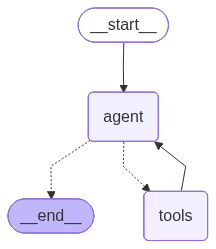

In [4]:
from langgraph.prebuilt import create_react_agent

# ReAct 에이전트 생성
agent = create_react_agent(
    model=MODEL,  
    tools=[get_weather],                    # 에이전트가 사용할 도구 목록
    prompt="당신은 도움이 되는 어시스턴트입니다."    # 에이전트의 역할과 동작을 정의하는 프롬프트
)
agent

In [5]:
# 에이전트 실행
result = agent.invoke(
    {"messages": [{"role": "user", "content": "오늘 서울 날씨 어때?"}]},  # 사용자 메시지 입력
)
# 결과 출력
print("=== 에이전트 응답 ===")
result

=== 에이전트 응답 ===


{'messages': [HumanMessage(content='오늘 서울 날씨 어때?', additional_kwargs={}, response_metadata={}, id='e0b87f04-9c1b-4088-b651-f0351e2ce01f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4j9P5jy9bIGlvSYeNG2k2V5i', 'function': {'arguments': '{"latitude":37.5665,"longitude":126.978}\n', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 224, 'prompt_tokens': 165, 'total_tokens': 389, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMsjwVA5CZEGARI3uG1WgO97hvKNC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9f4ac47b-d4f3-4600-9dc0-e824787bf71b-0', tool_calls=[{'name': 'get_weather', 'args': {'latitude': 37.5665, 'longit

In [6]:
result['messages'][0].pretty_print()

================================ Human Message =================================

오늘 서울 날씨 어때?


In [7]:
# 각 단계의 메시지 출력
print("=== 대화 과정 ===")
for i, message in enumerate(result['messages']):
    print(f"\n--- 메시지 {i+1} ---")
    message.pretty_print()

=== 대화 과정 ===

--- 메시지 1 ---
================================ Human Message =================================

오늘 서울 날씨 어때?

--- 메시지 2 ---
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_4j9P5jy9bIGlvSYeNG2k2V5i)
 Call ID: call_4j9P5jy9bIGlvSYeNG2k2V5i
  Args:
    latitude: 37.5665
    longitude: 126.978

--- 메시지 3 ---
================================= Tool Message =================================
Name: get_weather

구름 많음

--- 메시지 4 ---
================================== Ai Message ==================================

오늘 서울은 구름이 많습니다. 
원하시면 기온, 바람, 강수 확률 등 자세한 정보를 시간대별 예보로도 확인해 드릴게요. 어떤 정보가 필요하신가요?


## 사용자 정의 프롬프트 추가

`AgentState`는 LangGraph의 사전 구축된 채팅 에이전트에서 사용하는 상태(state) 클래스입니다.

```
class AgentState(TypedDict):
    """ReAct Agent가 사용하는 상태 모델"""

    # 대화 메시지 목록
    messages: Annotated[Sequence[AnyMessage], add_messages]
```

In [8]:
from langchain_core.messages import AnyMessage
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.prebuilt import create_react_agent

# 에이전트의 프롬프트 생성 함수
def prompt(state: AgentState, config: RunnableConfig) -> list[AnyMessage]:  
    # config에서 사용자 이름을 추출
    user_name = config["configurable"].get("user_name")
    # 시스템 메시지 생성: 사용자 이름을 포함
    system_msg = f"당신은 도움이 되는 어시스턴트입니다. 사용자를 {user_name}님으로 호칭하세요."
    # 시스템 메시지와 기존 상태의 메시지를 결합하여 반환
    return [{"role": "system", "content": system_msg}] + state["messages"]

# ReAct 에이전트 생성
agent = create_react_agent(
    model=MODEL,     # 사용할 LLM 모델 지정
    tools=[get_weather],      # 에이전트가 사용할 도구 목록
    prompt=prompt             # 함수를 이용한 동적 프롬프트 생성
)

# 에이전트 실행
result = agent.invoke(
    {"messages": [{"role": "user", "content":  "오늘 서울 날씨 어때?"}]},
    # 에이전트 실행을 위한 설정 정보
    config={"configurable": {"user_name": "홍길동"}}
)
# 각 단계의 메시지 출력
for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================

오늘 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_NZMOUJ5otkZs4kDl61Be6ILH)
 Call ID: call_NZMOUJ5otkZs4kDl61Be6ILH
  Args:
    latitude: 37.5665
    longitude: 126.978
================================= Tool Message =================================
Name: get_weather

구름 많음
================================== Ai Message ==================================

홍길동님, 현재 서울의 날씨는 구름이 많습니다. 필요하시면 오늘의 온도, 체감온도, 강수 확률 등 자세한 정보를 추가로 확인해 드릴게요. 어떤 정보가 필요하신가요?


## 메모리 추가

In [9]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import InMemorySaver

# 에이전트의 상태를 메모리에 저장 (프로그램이 종료되면 사라짐)
checkpointer = InMemorySaver()

# ReAct 에이전트 생성
agent = create_react_agent(
    model=MODEL,            # 사용할 LLM 모델 지정
    tools=[get_weather],             # 에이전트가 사용할 도구 목록
    checkpointer=checkpointer        # 에이전트의 상태를 저장하는 기능 추가
)

# 에이전트 실행을 위한 설정 정보
# 'thread_id'는 대화의 고유 식별자 역할
config = {"configurable": {"thread_id": "1"}}

# 에이전트 실행 (서울)
seoul_response = agent.invoke(
    {"messages": [{"role": "user", "content": "서울 날씨 어때?"}]},
    config  
)
# 에이전트 실행 (부산)
pusan_response = agent.invoke(
    {"messages": [{"role": "user", "content": "부산 날씨 어때?"}]},
    config
)

In [10]:
# 각 단계의 메시지 출력
for message in seoul_response['messages']:
    message.pretty_print()

================================ Human Message =================================

서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_KxYBluLj1WvyvbhqdwXwb63A)
 Call ID: call_KxYBluLj1WvyvbhqdwXwb63A
  Args:
    latitude: 37.5665
    longitude: 126.978
================================= Tool Message =================================
Name: get_weather

구름 많음
================================== Ai Message ==================================

서울 현재 날씨는 구름이 많습니다. 필요하시면 온도, 체감 온도, 강수 확률 등의 상세 정보도 알려드릴게요.


In [11]:
# 각 단계의 메시지 출력
for message in pusan_response['messages']:
    message.pretty_print()

================================ Human Message =================================

서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_KxYBluLj1WvyvbhqdwXwb63A)
 Call ID: call_KxYBluLj1WvyvbhqdwXwb63A
  Args:
    latitude: 37.5665
    longitude: 126.978
================================= Tool Message =================================
Name: get_weather

구름 많음
================================== Ai Message ==================================

서울 현재 날씨는 구름이 많습니다. 필요하시면 온도, 체감 온도, 강수 확률 등의 상세 정보도 알려드릴게요.
================================ Human Message =================================

부산 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_XrnZLYqrPSQuzpX8kG8ALShj)
 Call ID: call_XrnZLYqrPSQuzpX8kG8ALShj
  Args:
    latitude: 35.1796
    longitude: 129.0756
================================= Tool Message =================================
Name: get_weather

구름

## 구조화된 출력 반환

In [14]:
from pydantic import BaseModel
from langgraph.prebuilt import create_react_agent
from typing import Annotated, Literal

# 날씨 응답을 구조화하기 위한 모델
class WeatherPlan(BaseModel):
    conditions: Annotated[
        Literal["맑음", "흐림", "비", "눈"],
        "간결하고 필수적인 현재 날씨 상황만 포함합니다."
    ]
    recommendation: Annotated[
        Literal["집에 있기", "외출하기"],
        "현재 날씨를 고려해 사용자가 취할 행동을 제안합니다."
    ]
    rationale: Annotated[
        str,
        "한 줄 설명 (왜 그 판단을 했는지 간단히)"
    ]


# ReAct 에이전트 생성
agent = create_react_agent(
    model=MODEL,                # 사용할 LLM 모델 지정
    tools=[get_weather],                    # 에이전트가 사용할 도구 목록
    response_format=WeatherPlan        # 응답을 WeatherResponse 형식으로 구조화
)

# 에이전트 실행
response = agent.invoke(
    {"messages": [{"role": "user", "content":  "오늘 서울 날씨 어때?"}]}
)

response

{'messages': [HumanMessage(content='오늘 서울 날씨 어때?', additional_kwargs={}, response_metadata={}, id='4cae2d90-15ec-4c91-b9a4-6f4e3ac33991'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_iuC3OzyRMq9alMdAmSMCAbRT', 'function': {'arguments': '{"latitude":37.5665,"longitude":126.9780}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 353, 'prompt_tokens': 150, 'total_tokens': 503, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CMslse12IDubPKUHvdQVbdFFc7i1d', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a3fd509d-ad99-4af1-aaf1-ef0763ef39e5-0', tool_calls=[{'name': 'get_weather', 'args': {'latitude': 37.5665, 'longitu

In [15]:
# 구조화된 응답 추출
response["structured_response"]

WeatherPlan(conditions='흐림', recommendation='외출하기', rationale='현재 서울은 구름이 많아 햇빛이 거의 없고 바람은 약간 있습니다. 비나 눈 예보는 없으며, 외출해도 무난한 편입니다.')

In [16]:
# 각 단계의 메시지 출력
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

오늘 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_iuC3OzyRMq9alMdAmSMCAbRT)
 Call ID: call_iuC3OzyRMq9alMdAmSMCAbRT
  Args:
    latitude: 37.5665
    longitude: 126.978
================================= Tool Message =================================
Name: get_weather

구름 많음
================================== Ai Message ==================================

오늘 서울은 구름이 많은 편입니다.

원하시면 현재 기온이나 강수 확률 등 자세한 정보도 확인해 드릴게요.


In [17]:
response['messages'][-1].pretty_print()

================================== Ai Message ==================================

오늘 서울은 구름이 많은 편입니다.

원하시면 현재 기온이나 강수 확률 등 자세한 정보도 확인해 드릴게요.
